# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

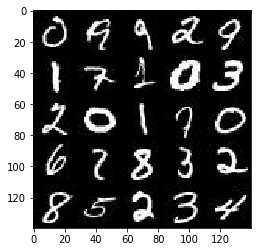

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

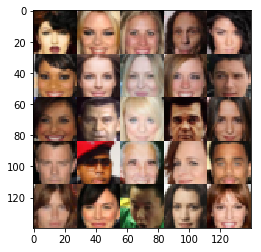

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(dtype = tf.float32, shape = (None, image_width, image_height, image_channels),
                                 name = 'real_images')
    #print (image_width, image_height, image_channels)
    
    z_input = tf.placeholder(dtype = tf.float32, shape = (None, z_dim), name = 'z_input')
    learing_rate = tf.placeholder(dtype = tf.float32, shape = None, name = 'lr')

    return real_images, z_input, learing_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leakyRelu(x, reuse = False, alpha = 0.2, name = 'lrelu'):
    # Suggested by reviewer:
    #with tf.variable_scope(name, reuse):
    #    f1 = 0.5 * (1 + leak)
    #    f2 = 0.5 * (1 - leak)
    #    return f1 * x + f2 * abs(x)
    
    return tf.maximum(alpha * x, x)
    
    

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # With a wave of my wand, I generate . . . MAGIC NUMBERS! WHAM-BAM-ALAKAZAM
        d1 = tf.layers.conv2d(images, 128, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        relu1 = leakyRelu(d1)
        #print(relu1.get_shape().as_list())
        
        d2 = tf.layers.conv2d(relu1, 256, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(d2, training = True)
        relu2 = leakyRelu(bn2)
        #print(relu2.get_shape().as_list())
        
        d3 = tf.layers.conv2d(relu2, 512, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(d3, training = True)
        relu3 = leakyRelu(bn3)
        #print(relu3.get_shape().as_list())
        
        d4 = tf.layers.conv2d(relu3, 1024, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(d4, training = True)
        relu4 = leakyRelu(bn4)
        #print(relu4.get_shape().as_list())
        
        
        flat = tf.reshape(relu4, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, 
                                kernel_initializer = tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2 
    
    with tf.variable_scope('generator', reuse = not is_train) as scope:
        # WHA-FLA-ABRACADABRA
        l1 = tf.layers.dense(z, 2*2*1024)
        
        l1 = tf.reshape(l1, (-1, 2, 2, 1024))
        l1 = tf.layers.batch_normalization(l1, training = is_train)
        l1 = leakyRelu(l1)
        #print(l1.get_shape().as_list())
        
        l2 = tf.layers.conv2d_transpose(l1, 512, 5, strides = 2, padding = 'same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training = is_train)
        l2 = leakyRelu(l2)
        #print(l2.get_shape().as_list())
        
        l3 = tf.layers.conv2d_transpose(l2, 256, 4, strides = 1, padding = 'valid', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training = is_train)
        l3 = leakyRelu(l3)
        #print(l3.get_shape().as_list())
        
        l4 = tf.layers.conv2d_transpose(l3, 128, 5, strides = 2, padding = 'same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        l4 = tf.layers.batch_normalization(l4, training = is_train)
        l4 = leakyRelu(l4)
        #print(l4.get_shape().as_list())
        
        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 5, strides = 2, padding = 'same', 
                                           kernel_initializer = tf.contrib.layers.xavier_initializer())
        #print(logits.get_shape().as_list())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    gen = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen, reuse = True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_real, 
                                                labels = tf.ones_like(dis_model_real) * (1 - smooth)))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, labels = tf.zeros_like(dis_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, labels = tf.ones_like(dis_model_fake)))
    
    dis_loss = dis_loss_fake + dis_loss_real
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    

    # Book keeping
    print_every, show_every = 10, 100    
    _, image_width, image_height, image_channels = data_shape
    steps = 0
    losses = []
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                noize = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: noize})
                sess.run(g_opt, feed_dict = {input_z: noize, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = sess.run(d_loss, feed_dict = {input_real: batch_images, input_z: noize})
                    train_loss_g = g_loss.eval({input_z: noize})
                    
                    print('Epoch {}/{}...'.format(epoch_i + 1, epochs),
                            'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                            'Generator Loss: {:.4f}'.format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    # gen_samples = sess.run(
                    #               generator(input_z, image_channels, reuse = True, training = False),
                    #               feed_dict = {input_z: sample_z})
                    # samples.append(gen_samples)
                                 
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
            # show final each epoch
            show_generator_output(sess, 36, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.4375... Generator Loss: 0.0032
Epoch 1/2... Discriminator Loss: 0.6304... Generator Loss: 1.4041
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 0.5483... Generator Loss: 2.8981
Epoch 1/2... Discriminator Loss: 2.2574... Generator Loss: 2.4890
Epoch 1/2... Discriminator Loss: 0.8309... Generator Loss: 1.1271
Epoch 1/2... Discriminator Loss: 0.6911... Generator Loss: 2.4532
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 1.9254
Epoch 1/2... Discriminator Loss: 1.8059... Generator Loss: 2.2596
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 2.8533


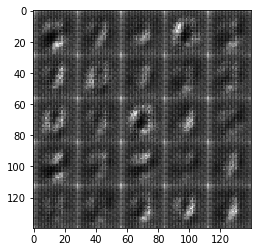

Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 1.2211
Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.6078... Generator Loss: 0.4353
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 1.1517
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 1.5899
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 1.5424
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 1.6655
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 1.4298


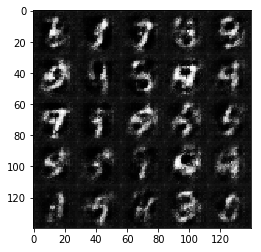

Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 1.4460
Epoch 1/2... Discriminator Loss: 1.5811... Generator Loss: 2.3025
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 1.3150
Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 1.7332
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 1.3208
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 1.3465
Epoch 1/2... Discriminator Loss: 1.7950... Generator Loss: 2.4285
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.4573
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.4691
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.5331


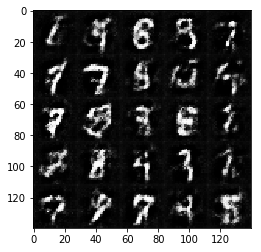

Epoch 1/2... Discriminator Loss: 1.6118... Generator Loss: 0.3727
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.5919
Epoch 1/2... Discriminator Loss: 1.4110... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.6027
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 2.1064
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 1.0407
Epoch 1/2... Discriminator Loss: 1.0985... Generator Loss: 1.5359
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 1.0027


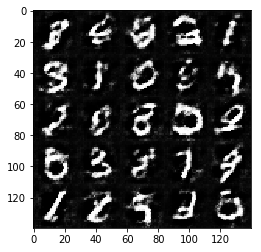

Epoch 1/2... Discriminator Loss: 1.5637... Generator Loss: 2.5701
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 2.5805
Epoch 1/2... Discriminator Loss: 1.0358... Generator Loss: 1.8339
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.5758
Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 1.0433
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 1.8367
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 0.5265
Epoch 1/2... Discriminator Loss: 1.6383... Generator Loss: 0.3852
Epoch 1/2... Discriminator Loss: 1.6371... Generator Loss: 0.3503


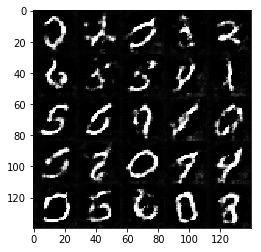

Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 0.5379
Epoch 1/2... Discriminator Loss: 1.2127... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 0.3953
Epoch 1/2... Discriminator Loss: 1.0824... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.4975
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 1.3271
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 2.6168
Epoch 1/2... Discriminator Loss: 1.7438... Generator Loss: 3.0195
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 0.6609


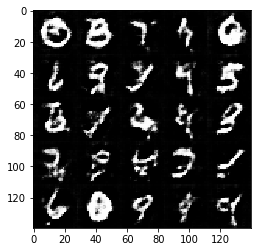

Epoch 1/2... Discriminator Loss: 1.0847... Generator Loss: 1.1892
Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.4353
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 2.1397
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 1.2434
Epoch 1/2... Discriminator Loss: 0.9791... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 0.4742
Epoch 1/2... Discriminator Loss: 1.7267... Generator Loss: 0.3333
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 0.9352
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.6176
Epoch 1/2... Discriminator Loss: 0.7855... Generator Loss: 1.0765


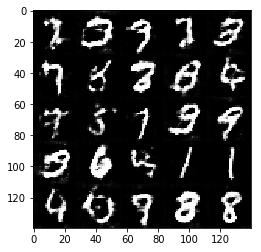

Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.5235... Generator Loss: 2.6064
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.9518
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.4389
Epoch 1/2... Discriminator Loss: 1.5067... Generator Loss: 0.4582
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.4935
Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 0.9918
Epoch 1/2... Discriminator Loss: 1.9031... Generator Loss: 0.2848
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.5668


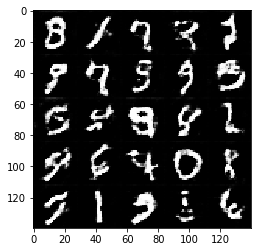

Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 1.3668
Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 2.0719
Epoch 1/2... Discriminator Loss: 0.9067... Generator Loss: 2.3090
Epoch 1/2... Discriminator Loss: 2.2746... Generator Loss: 4.2359
Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 1.8026
Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 2.2788
Epoch 1/2... Discriminator Loss: 1.4868... Generator Loss: 0.4424
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.5341
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.5133


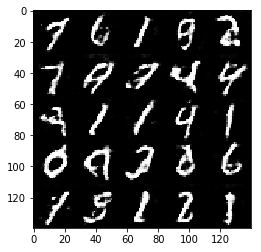

Epoch 1/2... Discriminator Loss: 1.7255... Generator Loss: 0.3264
Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 2.5245
Epoch 1/2... Discriminator Loss: 1.7654... Generator Loss: 2.5753


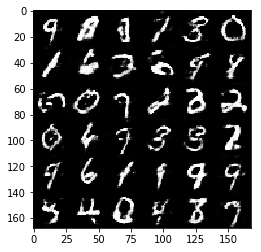

Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 2.1559
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 1.7658
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.1872
Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 1.7937
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 2.6690
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 0.7446


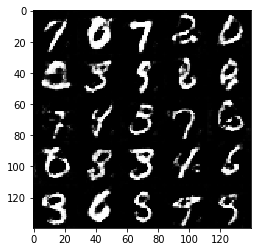

Epoch 2/2... Discriminator Loss: 1.1638... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 1.6595... Generator Loss: 0.3855
Epoch 2/2... Discriminator Loss: 0.8605... Generator Loss: 1.0510
Epoch 2/2... Discriminator Loss: 1.6538... Generator Loss: 0.4350
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.5245
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 0.8886
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 0.8407
Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 0.9040... Generator Loss: 1.1938


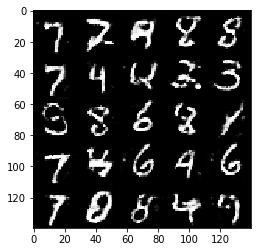

Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 1.7340
Epoch 2/2... Discriminator Loss: 0.7637... Generator Loss: 1.7231
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 2.7235
Epoch 2/2... Discriminator Loss: 2.2645... Generator Loss: 3.9179
Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 0.8114
Epoch 2/2... Discriminator Loss: 1.6895... Generator Loss: 0.3686
Epoch 2/2... Discriminator Loss: 1.2538... Generator Loss: 3.1384
Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.2947
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 0.8564


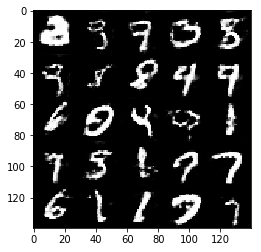

Epoch 2/2... Discriminator Loss: 1.4488... Generator Loss: 0.4566
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 0.8915
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.7871
Epoch 2/2... Discriminator Loss: 1.6190... Generator Loss: 0.4814
Epoch 2/2... Discriminator Loss: 1.5340... Generator Loss: 0.5170
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 1.3020
Epoch 2/2... Discriminator Loss: 0.6249... Generator Loss: 1.5300
Epoch 2/2... Discriminator Loss: 0.5332... Generator Loss: 2.4131
Epoch 2/2... Discriminator Loss: 0.9407... Generator Loss: 2.8180


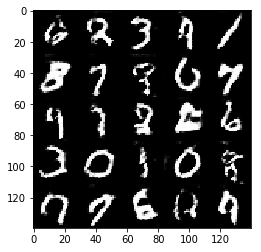

Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 1.4583
Epoch 2/2... Discriminator Loss: 2.0558... Generator Loss: 0.2955
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.4085
Epoch 2/2... Discriminator Loss: 0.7225... Generator Loss: 2.0743
Epoch 2/2... Discriminator Loss: 1.4952... Generator Loss: 3.2432
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.9971
Epoch 2/2... Discriminator Loss: 1.7071... Generator Loss: 0.3941
Epoch 2/2... Discriminator Loss: 0.6413... Generator Loss: 1.4982
Epoch 2/2... Discriminator Loss: 0.8616... Generator Loss: 1.1021
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 1.0476


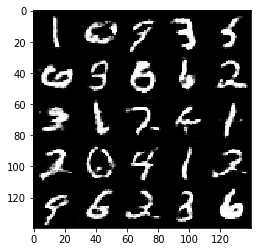

Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.2626
Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 0.7703... Generator Loss: 1.2680
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 1.0131
Epoch 2/2... Discriminator Loss: 2.1167... Generator Loss: 0.2359
Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.6857
Epoch 2/2... Discriminator Loss: 2.0811... Generator Loss: 0.2764
Epoch 2/2... Discriminator Loss: 2.3685... Generator Loss: 0.2107
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 2.6501


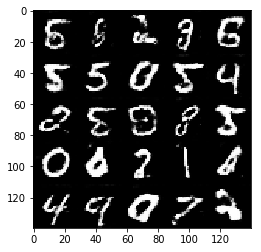

Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 0.5418
Epoch 2/2... Discriminator Loss: 1.4589... Generator Loss: 0.4953
Epoch 2/2... Discriminator Loss: 0.9796... Generator Loss: 2.0100
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 3.3571
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 0.5864... Generator Loss: 1.7162
Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 1.9976
Epoch 2/2... Discriminator Loss: 0.6069... Generator Loss: 1.7117
Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 2.4926
Epoch 2/2... Discriminator Loss: 0.5875... Generator Loss: 1.6476


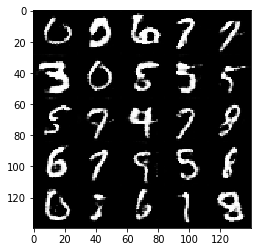

Epoch 2/2... Discriminator Loss: 0.6794... Generator Loss: 1.4197
Epoch 2/2... Discriminator Loss: 1.4796... Generator Loss: 2.9296
Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 1.3787
Epoch 2/2... Discriminator Loss: 1.2453... Generator Loss: 0.6546
Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 1.3056
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 3.1519
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.7843
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 1.8840
Epoch 2/2... Discriminator Loss: 0.7974... Generator Loss: 1.4261


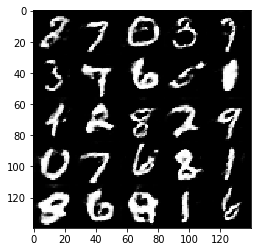

Epoch 2/2... Discriminator Loss: 0.6639... Generator Loss: 1.4118
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.8658
Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 3.4242
Epoch 2/2... Discriminator Loss: 1.1722... Generator Loss: 3.5176
Epoch 2/2... Discriminator Loss: 0.6450... Generator Loss: 1.5209
Epoch 2/2... Discriminator Loss: 1.6008... Generator Loss: 1.8034
Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 1.5030
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.6977
Epoch 2/2... Discriminator Loss: 0.9916... Generator Loss: 2.1031


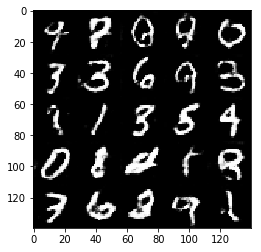

Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 1.3125
Epoch 2/2... Discriminator Loss: 1.0974... Generator Loss: 0.9233
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 0.9003
Epoch 2/2... Discriminator Loss: 1.6407... Generator Loss: 0.4110
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 2.2052
Epoch 2/2... Discriminator Loss: 0.6513... Generator Loss: 1.7362
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 1.0292


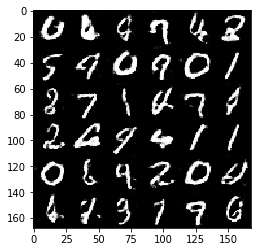

In [14]:
batch_size = 64
z_dim = 64 # was 64
learning_rate = 0.0002
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.4467... Generator Loss: 15.0305
Epoch 1/1... Discriminator Loss: 3.0862... Generator Loss: 11.4628
Epoch 1/1... Discriminator Loss: 1.8560... Generator Loss: 4.1346
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 2.3888
Epoch 1/1... Discriminator Loss: 2.0312... Generator Loss: 2.6533
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.4111


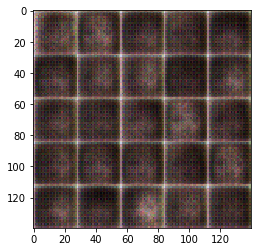

Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.3811
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.6727... Generator Loss: 0.3522
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7169


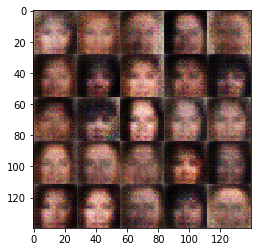

Epoch 1/1... Discriminator Loss: 1.7490... Generator Loss: 0.3031
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.4727
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 1.5467
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.2695
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 1.7041
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 1.3832
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.2959


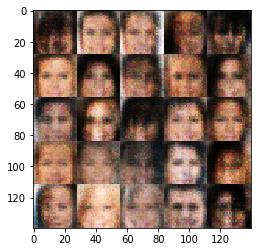

Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 1.9095
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 2.0877
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 1.1504
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 1.8761
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.8457
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.5242


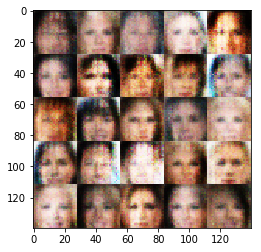

Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.4129
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 3.5740... Generator Loss: 0.0861
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.4907


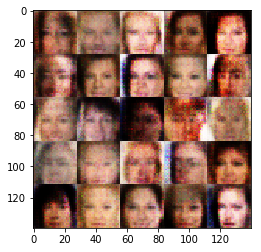

Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 2.1499... Generator Loss: 0.2008
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 1.7634
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.7681
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 2.4297
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.7573
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 2.5579
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.4582


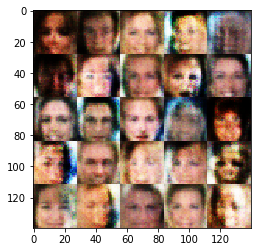

Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.4819
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.1517
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 2.0064
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 3.8504
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 1.7257
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.7011


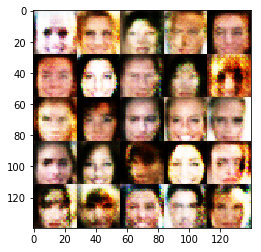

Epoch 1/1... Discriminator Loss: 0.5025... Generator Loss: 3.9103
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.6576
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 3.8147
Epoch 1/1... Discriminator Loss: 2.1756... Generator Loss: 4.3034
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 2.3561
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 2.3663
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 0.7121... Generator Loss: 4.2897


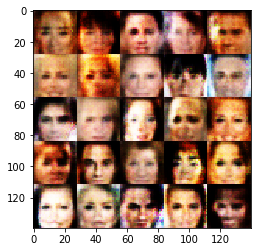

Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 5.6915
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 4.7189
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 1.6532
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 0.5539... Generator Loss: 1.9772
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 3.1901
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 1.7440
Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 6.0379
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 1.9190
Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 2.7882


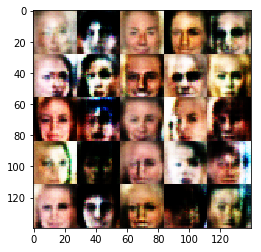

Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 1.6959
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 5.0419
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 4.3083
Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 1.3586
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 4.7219
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 4.5223
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 4.7030
Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 3.0897


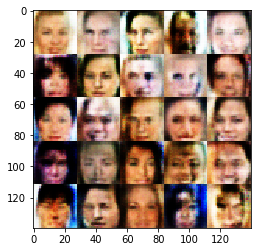

Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.5887
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 6.9830
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 3.5176
Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 4.4249
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 4.6153
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.4991
Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.9093
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 3.9842


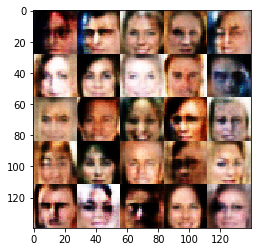

Epoch 1/1... Discriminator Loss: 0.4518... Generator Loss: 2.4978
Epoch 1/1... Discriminator Loss: 1.8445... Generator Loss: 0.3122
Epoch 1/1... Discriminator Loss: 0.5885... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 0.6184... Generator Loss: 4.4499
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.2706
Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 5.1937
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 5.2972
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 4.4203
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 7.1014


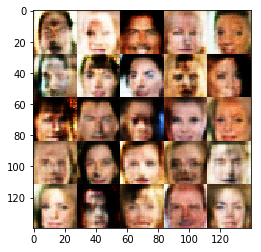

Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 4.4267
Epoch 1/1... Discriminator Loss: 1.8170... Generator Loss: 5.6684
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 3.7990
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 3.8176
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 4.3185
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 4.9757
Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 2.2210... Generator Loss: 5.7287
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 2.7382
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 4.6160


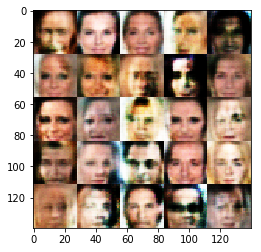

Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 2.7635
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 4.6077
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 5.4156
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 5.3868
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 4.5224
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 2.9364
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 5.0849
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 4.2689
Epoch 1/1... Discriminator Loss: 2.6740... Generator Loss: 6.8632


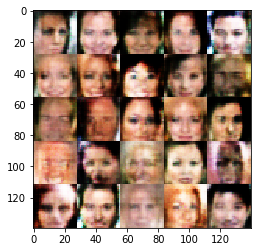

Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 2.1290
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.0555
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 3.2588
Epoch 1/1... Discriminator Loss: 0.4437... Generator Loss: 3.4733
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 4.5395
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 2.6583
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 2.3266
Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 3.5955
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 2.6517


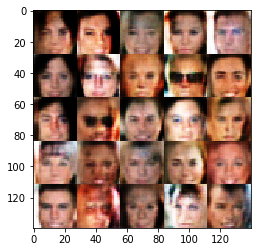

Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 2.7886
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 1.9802
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.4066
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 3.5095
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 4.0224
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 5.7812
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 2.7115
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 2.0754


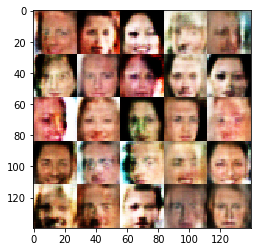

Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 6.0772
Epoch 1/1... Discriminator Loss: 1.9620... Generator Loss: 3.5603
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 5.2282
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 5.7743
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 4.3736
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 4.2082
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 4.6865
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 3.4729
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 4.2044
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 2.3609


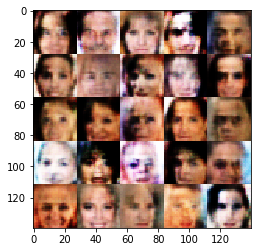

Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 3.2884
Epoch 1/1... Discriminator Loss: 0.3481... Generator Loss: 4.2294
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 2.2365
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 2.8585
Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 1.8236
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 4.1755
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 0.3719... Generator Loss: 4.6619
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 2.7020
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 3.3677


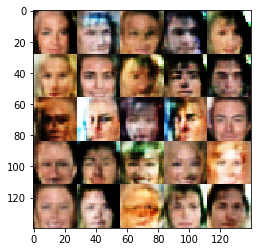

Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 3.3710
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 7.1553
Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 6.7651
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 3.4340
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 5.6255
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 3.8469
Epoch 1/1... Discriminator Loss: 0.5251... Generator Loss: 2.1355
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 5.9407
Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 3.9467


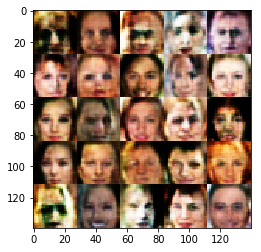

Epoch 1/1... Discriminator Loss: 2.8341... Generator Loss: 0.1305
Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 1.4642
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 1.8300
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 5.3171
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 3.9214
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 4.3900
Epoch 1/1... Discriminator Loss: 1.8616... Generator Loss: 0.3179
Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 2.6814
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 6.5859
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 4.2100


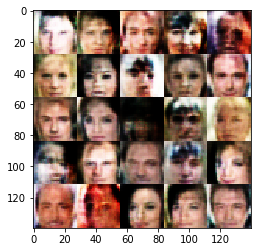

Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 3.3950
Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 4.4486
Epoch 1/1... Discriminator Loss: 1.7039... Generator Loss: 4.8677
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 4.7829
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 6.0518
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 3.8003
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 4.3893
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 6.3896
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 4.5674
Epoch 1/1... Discriminator Loss: 0.3371... Generator Loss: 4.8238


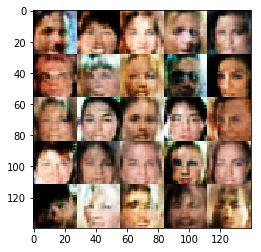

Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 5.3096
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 3.5287
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 4.3642
Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 5.7047
Epoch 1/1... Discriminator Loss: 0.3596... Generator Loss: 4.2471
Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 5.3103
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 4.1067
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 0.4340... Generator Loss: 2.4490


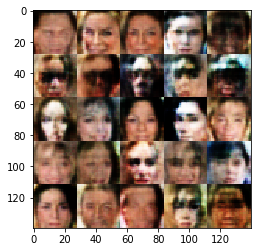

Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 4.1507
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 3.2833
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 4.2225
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 2.5200
Epoch 1/1... Discriminator Loss: 0.5385... Generator Loss: 3.3051
Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 4.6111
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.9244
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 2.9038
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 4.1630
Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 4.2583


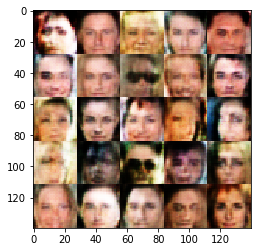

Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 4.7800
Epoch 1/1... Discriminator Loss: 0.3373... Generator Loss: 6.2463
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 4.5520
Epoch 1/1... Discriminator Loss: 2.0654... Generator Loss: 5.6631
Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 4.4747
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 3.8846
Epoch 1/1... Discriminator Loss: 0.3468... Generator Loss: 5.6982
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 5.5513
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 2.8045
Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 2.8741


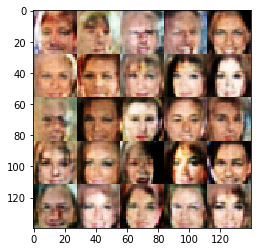

Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 4.7773
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 5.5957
Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 3.5219
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 2.6797
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 3.8209
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 4.5338
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 4.0770
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 4.0973
Epoch 1/1... Discriminator Loss: 0.3531... Generator Loss: 5.0780
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 2.3780


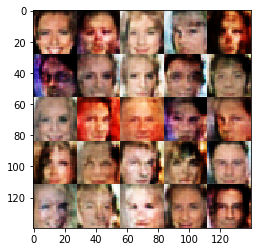

Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 3.8688
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 7.0008
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 8.3425
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 3.1085
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 6.3223
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 3.9742
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 3.8646
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 3.7430
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 6.3532


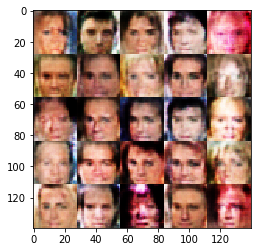

Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 1.8682
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 6.8171
Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 2.8624
Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 4.5316
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 4.1958
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 4.4541
Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 4.7294
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 5.5865
Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 8.2397
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 2.2387


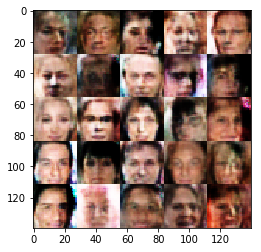

Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 3.4981
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 4.5875
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 3.4622
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 2.9015
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 3.4606
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 4.1272


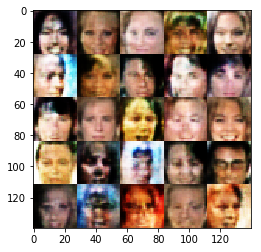

Epoch 1/1... Discriminator Loss: 0.4988... Generator Loss: 6.5675
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 5.6817
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.6224
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 5.6670
Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 4.4369
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 6.0111
Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 2.7965
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 5.1183
Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 6.6275
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 3.9539


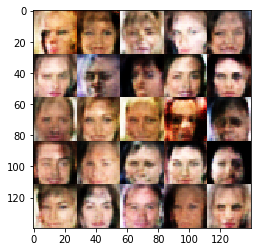

Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 2.2706
Epoch 1/1... Discriminator Loss: 0.3361... Generator Loss: 5.3456
Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 4.6454
Epoch 1/1... Discriminator Loss: 4.5541... Generator Loss: 9.1362
Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 2.3276
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 4.0666
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 4.5917
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 1.9972
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 2.7840


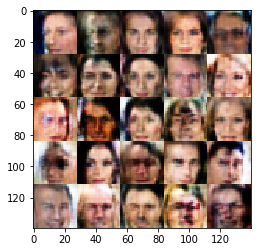

Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.3986
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 4.1887
Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 4.8273
Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 4.3350
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 4.9682
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 2.6407
Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 7.2502
Epoch 1/1... Discriminator Loss: 2.8603... Generator Loss: 8.6414
Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 3.6952
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 7.3189


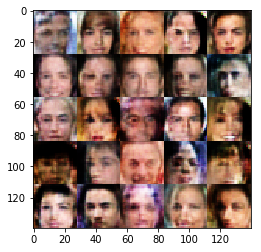

Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 5.8129
Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 5.7409
Epoch 1/1... Discriminator Loss: 0.3531... Generator Loss: 4.3001
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 4.8377
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 3.6295
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 5.2359


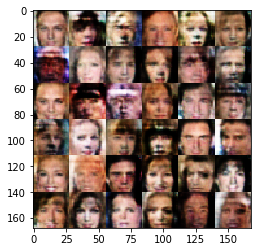

In [15]:
batch_size = 64
z_dim = 64
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.